<a href="https://colab.research.google.com/github/balsrini/Assignment6/blob/master/Assignment6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
from keras.models import Model
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Concatenate
np.random.seed(2017) 
#from keras.models import Sequential
#from keras.layers.convolutional import Convolution2D, MaxPooling2D
#from keras.layers import Activation, Flatten, Dense, Dropout
#from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [71]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

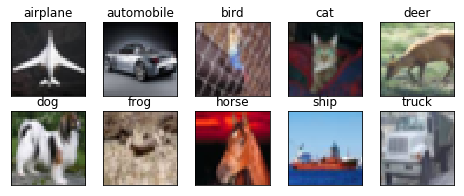

In [72]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [73]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [74]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [75]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [76]:
# Define the model
#visible = Input(shape=(32,32,3))
#conv1 = Conv2D(64,3,3,activation='relu')(visible)
#conv2 = Conv2D(128,3,3,activation='relu')(conv1)
#drop = Dropout(0.1)(conv2)
#maxP = MaxPooling2D(pool_size=(2,2))(drop)

inputVal = Input(shape=(32,32,3))
conv1 = Conv2D(48,3,3,activation='relu')(inputVal)

#Normal Convolution
conv2 = Conv2D(48,3,3,activation='relu')(conv1)

#Spatial Separable Convolution
conv3 = Conv2D(96,3,1)(conv2)
conv4 = Conv2D(96,1,3)(conv3)

#depthwise Separable Convolution
conv5 = SeparableConv2D(128,3,3)(conv4)

#BatchNormalization
conv5_norm = BatchNormalization()(conv5)
conv5_norm_activation = Activation('relu')(conv5_norm)

#Group Convoloution 3x3
groupConv = Conv2D(256,3,3)(conv5_norm_activation)
groupConv_norm = BatchNormalization()(groupConv)
groupConv_norm_activation = Activation('relu')(groupConv_norm)
group1Conv = Conv2D(256,3,3,activation='relu')(groupConv_norm_activation)

#group Convolution 5x5
group2Conv = Conv2D(256,(5,5))(conv5_norm_activation)
group2Conv_norm = BatchNormalization()(group2Conv)
group2Conv_norm_activation = Activation('relu')(group2Conv_norm)

#concatenate
concat1 = Concatenate()([group1Conv,group2Conv_norm_activation])

#group convolution 3x3 with dilation 1
group3Conv = Conv2D(256,(3,3),padding='same',dilation_rate=1)(concat1)
group3Conv_norm = BatchNormalization()(group3Conv)
group3Conv_norm_activation = Activation('relu')(group3Conv_norm)

#group convolution 3x3 with dilation 2
group4Conv = Conv2D(256,(3,3),padding='same',dilation_rate=2)(concat1)
group4Conv_norm = BatchNormalization()(group4Conv)
group4Conv_norm_activation = Activation('relu')(group4Conv_norm)

#concatenate
concat2 = Concatenate()([group3Conv_norm_activation,group4Conv_norm_activation])

#Transition layer
maxPool = MaxPooling2D(pool_size=(2,2))(concat2)
transistionLayer = Conv2D(64,1,1,activation='relu')(maxPool)

#Prediction Layer
lastLayer = Conv2D(10,10,10,activation='softmax')(transistionLayer)

#Flatter
flatten = Flatten()(lastLayer)

model = Model(inputs= inputVal, outputs=flatten)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu")`
  if __name__ == '__main__':
C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu")`
  if sys.path[0] == '':
C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 1))`
  from ipykernel import kernelapp as app
C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (1, 3))`
  app.launch_new_instance()
C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3))`
C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to th

In [77]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_305 (Conv2D)             (None, 30, 30, 48)   1344        input_41[0][0]                   
__________________________________________________________________________________________________
conv2d_306 (Conv2D)             (None, 28, 28, 48)   20784       conv2d_305[0][0]                 
__________________________________________________________________________________________________
conv2d_307 (Conv2D)             (None, 26, 28, 96)   13920       conv2d_306[0][0]                 
__________________________________________________________________________________________________
conv2d_308

C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
C:\Balaji\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 66s 170ms/step - loss: 0.0422 - acc: 0.9860 - val_loss: 1.4901 - val_acc: 0.7454
Epoch 2/50
390/390 [==============================] - 66s 171ms/step - loss: 0.0492 - acc: 0.9830 - val_loss: 1.4990 - val_acc: 0.7474
Epoch 3/50
390/390 [==============================] - 67s 171ms/step - loss: 0.0482 - acc: 0.9832 - val_loss: 1.4353 - val_acc: 0.7699
Epoch 4/50
390/390 [==============================] - 67s 171ms/step - loss: 0.0382 - acc: 0.9871 - val_loss: 1.6373 - val_acc: 0.7408
Epoch 5/50
390/390 [==============================] - 66s 169ms/step - loss: 0.0380 - acc: 0.9868 - val_loss: 1.6908 - val_acc: 0.7241
Epoch 6/50
390/390 [==============================] - 66s 169ms/step - loss: 0.0458 - acc: 0.9842 - val_loss: 1.6097 - val_acc: 0.7429
Epoch 7/50
390/390 [==============================] - 66s 169ms/step - loss: 0.0415 - acc: 0.9855 - val_loss: 1.5006 - val_acc: 0.7609
Epoch 8/50
390/390 [==============================] - 6

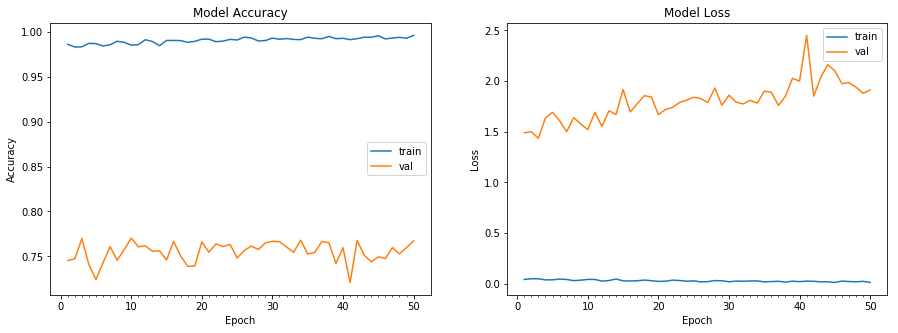

Accuracy on test data is: 76.74


In [79]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))